In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import os
import glob
import pickle

from scipy import ndimage
from skimage.segmentation import flood_fill

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import matplotlib.path as mpath
# import cmocean
# import seaborn as sns

In [4]:
datapd = pd.read_csv('List57.csv')

In [5]:
def ispickleexists(n, p0):
    p = p0 + n + '.pickle'
    if os.path.exists(p):
        # print('    [o] {} exists.'.format(p))
        return True
    else:
        return False

def openpickle(n, p0):
    p = p0 + n + '.pickle'
    d = pd.read_pickle(p)
    # with open(p, 'rb') as df:
    #     d = pickle.load(df)
    return d

def find_first_non_nan_row(da):
    """
    Finds the first row in each column where the value is not NaN.
    Returns:
        An xarray DataArray containing the coordinates of the first non-NaN value in each column.
    """
    # Find non-NaN values
    not_nan = ~da.isnull()
    # Get the indices of the first non-NaN value 
    first_non_nan_indices = not_nan.argmax(da.dims[len(da.dims)-2])
    # Get the corresponding coordinate values
    first_non_nan_rows = da[da.dims[len(da.dims)-2]][first_non_nan_indices]
    return first_non_nan_rows

def detect_polynya(daice, daarea, ice_threshold, area_threshold):
    s = ndimage.generate_binary_structure(2,2)
    da_masked = xr.DataArray(np.nan*np.empty_like(daice), dims = daice.dims, coords = daice.coords)
    for year in daice.time:
        ice0 = daice.sel(time = year)
        icenew = ice0 <= ice_threshold
        ice = xr.where(np.isnan(ice0), True, icenew)   # get rid of "coastal polynya" 
        ice = xr.where(ice0[ice0.dims[len(ice0.dims)-2]] == find_first_non_nan_row(ice0), True, ice) # buffering (one more layer)
        labeled_image, num_features = ndimage.label(ice, structure = s)
        if num_features <= 2:
            continue
        mask = np.zeros_like(labeled_image)
        for i in range(2, num_features+1):
            area = daarea.where(labeled_image == i).sum()/1e6  # m2 -> km2
            if (area > area_threshold[0]) and (area < area_threshold[1]):  # the area of open 'polynya' within the sea ice extent is small
                mask[labeled_image == i] = 1
        da_masked.loc[year] = xr.where(mask, ice0, np.nan)
    return da_masked #.mean('time'), da_masked.count('time')


def savepickle(n, p0, sf):
    p = p0 + n + '.pickle'
    with open(p, 'wb') as wf:
        pickle.dump(sf, wf, pickle.HIGHEST_PROTOCOL)

In [ ]:
ice_thresholds = np.arange(0, 100, step=1)
area_threshold = [10000, 1000000]

def count_polynya_area(ds, ice_threshold, area_threshold):
    masked = detect_polynya(ds.siconc, ds.areacello, ice_threshold, area_threshold)
    polynya_count = masked.count('time')
    return ds.areacello.where(polynya_count > 0).sum().values.item()
    
datap0 = '../../SO_data/data_siconc_w_area/'
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']
    print("{} {}".format(i, name))
    if pd.isna(datapd.at[i, 'xname']):
        print("    [x] doesn't have regular grid.")
        continue
    if ispickleexists(name, '../../SO_data/data_polynya_count/'):
        print("[o] exist.")
        continue
    if ispickleexists(name, datap0):
        ds = openpickle(name, datap0)
        area_count = []
        for ice_threshold in ice_thresholds:
            area_count.append(count_polynya_area(ds, ice_threshold, area_threshold))
            # print("    {} : ".format(ice_threshold), end = '')

        savepickle(name, '../../SO_data/data_polynya_count/', area_count)
        print("[*] complete!")

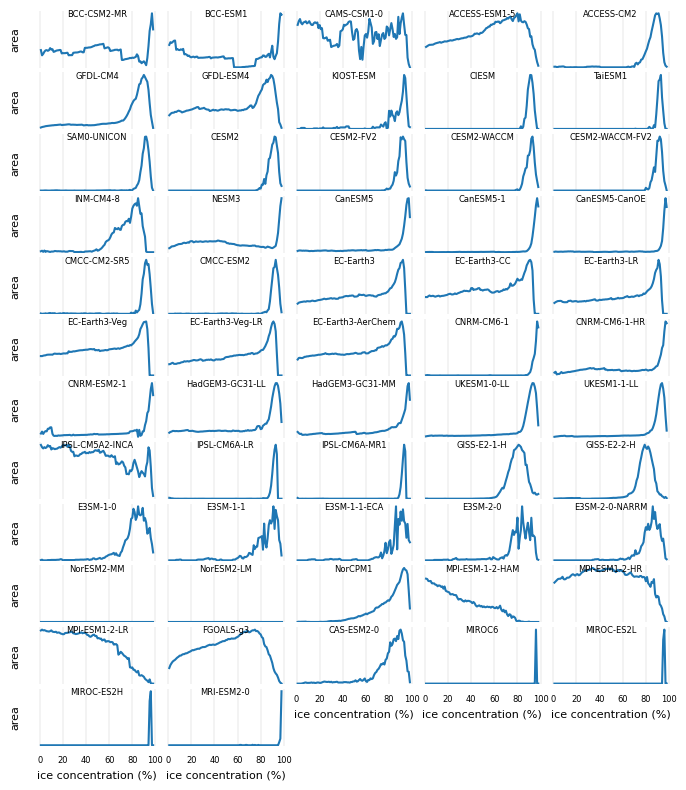

In [46]:
p0 = '../../SO_data/data_polynya_count/'
# plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(6.5, 7.5))
n = 0
ice_thresholds = np.arange(0, 100, step=1)

for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']
    if ispickleexists(name, p0):
        n+=1
        ds = openpickle(name, p0)
        ax = fig.add_subplot(12, 5, n)
        plt.subplots_adjust(left=0.01,
                            bottom=0.01, 
                            right=0.99, 
                            top=0.99, 
                            wspace=0.04, 
                            hspace=0.08)
        if np.max(ds)>0:
            ax.plot(ice_thresholds[1:-1], ds[1:-1]/np.max(ds))
        else:
            ax.plot(ice_thresholds[1:-1], ds[1:-1])
        if n == 1:
            # x_min, x_max = ax.get_xlim()
            y_min, y_max = ax.get_ylim()
        else:
            ax.set_ylim((y_min, y_max))
        ax.tick_params(labelsize = 6)
        ax.set_title(name, fontsize=6, y=1.0, pad=-4)
        ax.set_xticks([0,20,40,60,80,100])
        
        if n<=52:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('ice concentration (%)', fontsize=8)
        ax.set_yticklabels([])
        ax.set_frame_on(False)
        ax.tick_params(tick1On=False)
        # ax.axis('off')

        # ax.grid() 
        ax.xaxis.grid(True,'major', ls='-', lw=0.2)
        # if n>52:
        #     # ax.set_xticks([])
        #     ax.spines["bottom"].set_visible(True)
        if n%5==1:
            ax.set_ylabel('area', fontsize=8)

In [83]:
ds = openpickle('IPSL-CM5A2-INCA', '../../SO_data/data_siconc_w_area/')

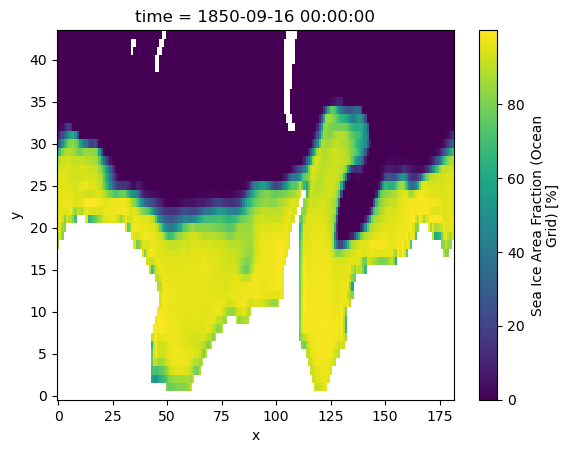

In [86]:
ds.siconc.isel(time=0).plot()

In [87]:
# ds.siconc.isel(time = 0).where(ds.siconc.isel(time = 0)<10).plot()

s = ndimage.generate_binary_structure(2,2)
da_masked = xr.DataArray(np.nan*np.empty_like(ds.siconc.isel(time = 0)), dims = ds.siconc.isel(time = 0).dims, coords = ds.siconc.isel(time = 0).coords)
    # for year in daice.time:
    #     ice0 = daice.sel(time = year)
    #     icenew = ice0 <= ice_threshold
    #     ice = xr.where(np.isnan(ice0), True, icenew)   # get rid of "coastal polynya" 
    #     ice = xr.where(ice0[ice0.dims[len(ice0.dims)-2]] == find_first_non_nan_row(ice0), True, ice) # buffering (one more layer)
    #     labeled_image, num_features = ndimage.label(ice, structure = s)
    #     if num_features <= 2:
    #         continue
    #     mask = np.zeros_like(labeled_image)
    #     for i in range(2, num_features+1):
    #         area = daarea.where(labeled_image == i).sum()/1e6  # m2 -> km2
    #         if (area > area_threshold[0]) and (area < area_threshold[1]):  # the area of open 'polynya' within the sea ice extent is small
    #             mask[labeled_image == i] = 1
    #     da_masked.loc[year] = xr.where(mask, ice0, np.nan)
    # return da_masked #.mean('time'), da_masked.count('time')

In [121]:
ds

<xarray.Dataset> Size: 8MB
Dimensions:    (y: 44, x: 182, time: 250)
Coordinates:
    nav_lat    (y, x) float32 32kB -78.19 -78.19 -78.19 ... -40.22 -40.22 -40.22
    nav_lon    (y, x) float32 32kB 78.0 80.0 82.0 84.0 ... 74.0 76.0 78.0 80.0
  * time       (time) object 2kB 1850-09-16 00:00:00 ... 2099-09-16 00:00:00
Dimensions without coordinates: y, x
Data variables:
    siconc     (time, y, x) float32 8MB nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    areacello  (y, x) float32 32kB nan nan nan nan ... 2.884e+10 2.884e+10 0.0
    newlat     (y, x) float32 32kB -78.19 -78.19 -78.19 ... -40.22 -40.22 -40.22
    newlon     (y, x) float32 32kB 78.0 80.0 82.0 84.0 ... 74.0 76.0 78.0 80.0

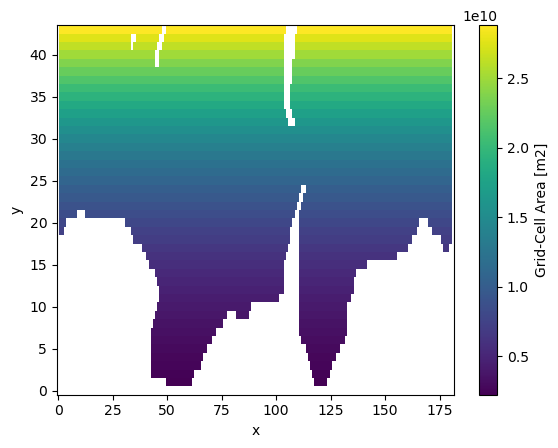

In [116]:
ds.areacello.where(ds.areacello>0).plot()

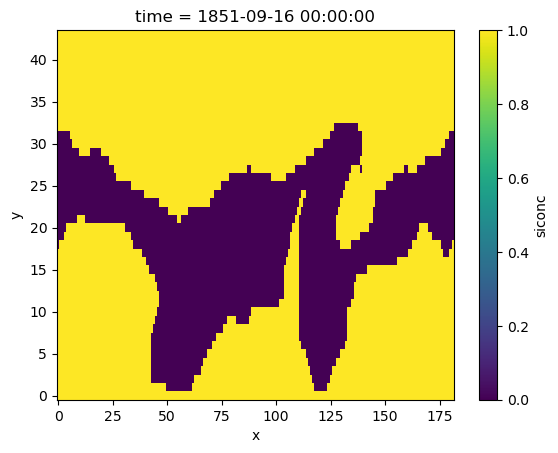

In [109]:
ice0 = ds.siconc.isel(time = 1)
icenew = ice0 <= 10
ice = xr.where(np.isnan(ice0), True, icenew)   # get rid of "coastal polynya" 
# ice = xr.where(ice0[ice0.dims[len(ice0.dims)-2]] == find_first_non_nan_row(ice0), True, ice)
# ice.plot()
ice.plot()

In [110]:
labeled_image, num_features = ndimage.label(ice, structure = s)

In [111]:
mask = np.zeros_like(labeled_image)

In [79]:
for i in range(2, num_features+1):
    area = daarea.where(labeled_image == i).sum()/1e6  # m2 -> km2
    print(area)

NameError: name 'daarea' is not defined

In [6]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [9]:
def plot_multi_map(datapd, ice_threshold, title_threshold=False, figsize = (7, 8)):
    fig = plt.figure(figsize=figsize)
    
    n = 1

    for i in range(0, len(datapd)):
        name = datapd.at[i, 'source_id']
        dataname = name + '_'+ str(ice_threshold)
        if not ispickleexists(dataname, 'data_polynya/'):
            continue
        ds = openpickle(dataname, 'data_polynya/')
        ax = fig.add_subplot(8, 8, n, projection=ccrs.SouthPolarStereo())
        plt.subplots_adjust(
            left=0.01,
            bottom=0.01,
            right=0.99,
            top=0.99,
            wspace=0.04,
            hspace=0.04
        )
        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
        if title_threshold:
            if ice_threshold == 'mean':
                title = str(round(ds.threshold.values.item())) + '%'
            else:
                title = str(ice_threshold) + '%'
            ax.text(0,-90, title, fontsize=6)
        ax.set_title(name, fontsize=6, pad=-0.5)
        pltx = ds.newlon
        plty = ds.newlat
        ice_max = ds.ice_max
        polynya_freq = ds.polynya_freq


        im = ax.pcolormesh(pltx, plty, ice_max, 
                           transform=ccrs.PlateCarree(), 
                           vmin=0, vmax=100, 
                           cmap=cmocean.cm.ice)
        
        im2 = ax.pcolormesh(pltx, plty, polynya_freq, 
                            transform=ccrs.PlateCarree(), 
                            vmin = 0, vmax = 0.20, cmap=plt.cm.Spectral)
        ax.add_feature(cfeature.LAND, zorder=1)#, color='0.8')
        ax.add_feature(cfeature.COASTLINE, linewidth=0.2)
        ax.set_boundary(circle, transform=ax.transAxes)
        
        n = n+1       
        
    cbar_ax1 = fig.add_axes([0.65, 0.11, 0.30, 0.01])
    cbar1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
    cbar1.set_label('Maximum sea ice coverage (%)', size=8, labelpad=-0.1)
    cbar1.ax.tick_params(labelsize=6,direction='in') 
    
    cbar_ax2 = fig.add_axes([0.65, 0.06, 0.30, 0.01])
    cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal')
    cbar2.set_label('Frequency of appearance', size=8, labelpad=-0.1)
    cbar2.ax.tick_params(labelsize=6,direction='in')
    savename = 'Polynya_Multi' + '_' + str(ice_threshold) + '.png'
    fig.savefig(savename, dpi = 300)


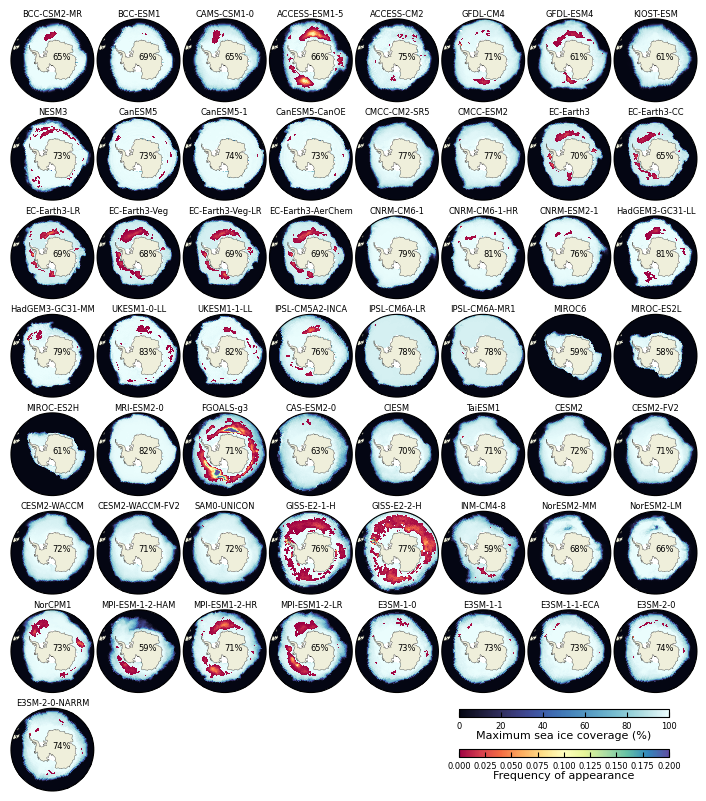

In [13]:
plot_multi_map(datapd, 'mean', title_threshold=True)

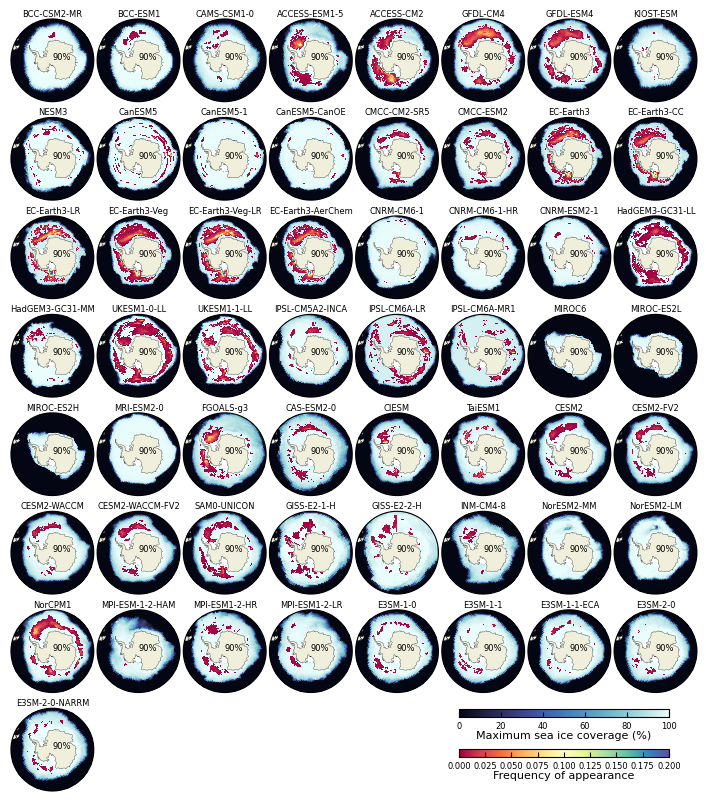

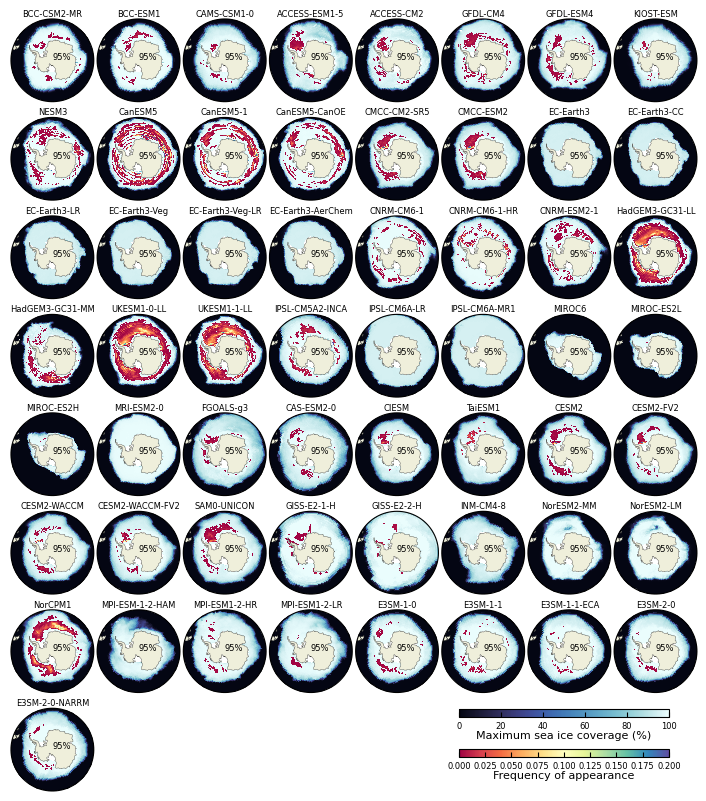

In [10]:
for ice_threshold in ice_thresholds:
    savename = 'Polynya_Multi' + '_' + str(ice_threshold) + '.png'
    if os.path.exists(savename):
        # print('    [o] {} exists.'.format(p))
        continue    
    plot_multi_map(datapd, ice_threshold, title_threshold=True)

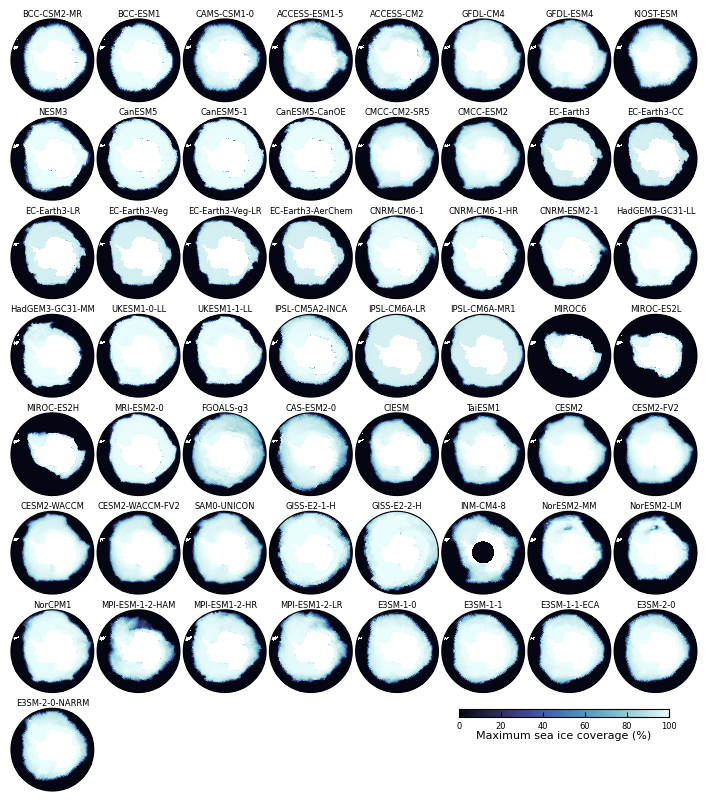

In [26]:
def plot_max_map(datapd, figsize = (7, 8)):
    fig = plt.figure(figsize=figsize)
    n = 1
    for i in range(0, len(datapd)):
        name = datapd.at[i, 'source_id']
        if not ispickleexists(name, 'data_siconc_w_area/'):
            continue
        ds = openpickle(name, 'data_siconc_w_area/')
        ax = fig.add_subplot(8, 8, n, projection=ccrs.SouthPolarStereo())
        plt.subplots_adjust(
            left=0.01,
            bottom=0.01,
            right=0.99,
            top=0.99,
            wspace=0.04,
            hspace=0.04
        )
        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    
        ax.set_title(name, fontsize=6, pad=-0.5)
        pltx = ds.newlon
        plty = ds.newlat
        ice_max = ds.siconc.max('time')
        
        im = ax.pcolormesh(pltx, plty, ice_max, 
                           transform=ccrs.PlateCarree(), 
                           vmin=0, vmax=100, 
                           cmap=cmocean.cm.ice)
        
        ax.set_boundary(circle, transform=ax.transAxes)
        
        n = n+1       
        
    cbar_ax1 = fig.add_axes([0.65, 0.11, 0.30, 0.01])
    cbar1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
    cbar1.set_label('Maximum sea ice coverage (%)', size=8, labelpad=-0.1)
    cbar1.ax.tick_params(labelsize=6,direction='in')

plot_max_map(datapd)

In [94]:
ds = openpickle('FGOALS-g3', 'data_siconc_w_area/')

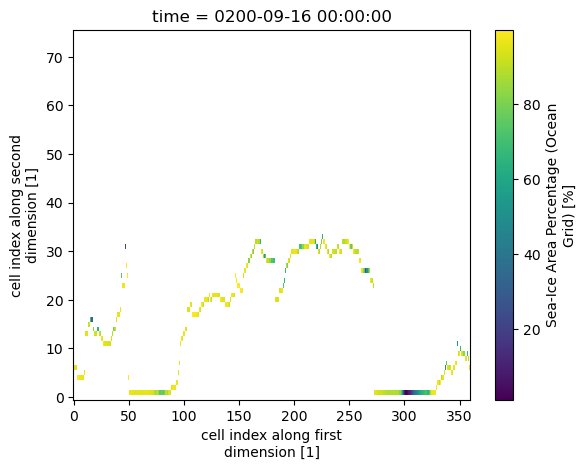

In [99]:
ds.siconc.where(ds.siconc.j == find_first_non_nan_row(ds.siconc)).isel(time=0).plot()

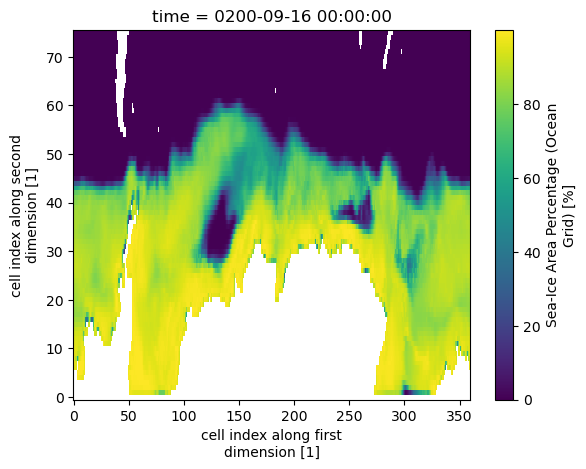

In [91]:
ds.siconc.isel(time = 0).plot()